In [1]:
import os, sys
import pickle as pkl
import pandas as pd
import numpy as np 

import sklearn
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml, sgnn

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

print(sys.version)

for i in [pd, np, sklearn, sns, lgb, xgb, cb]:
    print(i.__name__, i.__version__)

2024-05-21 11:38:31.431239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 11:38:31.988694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
numpy 1.26.4
sklearn 1.4.2
seaborn 0.13.2
lightgbm 4.3.0
xgboost 2.0.3
catboost 1.2.5


In [2]:
pd.set_option('display.max_colwidth', 100)

data_path = 'data'
img_path = 'img'
result_path = 'result'
if not os.path.isdir(img_path):
    os.mkdir(img_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('org', data_path, 'flood.csv'),
        ('test', data_path, 'test.csv'),
        ('type', data_path, 'type.pkl'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

model_file = os.path.join(result_path, 'stk_s4_ep5.pkl')
df_var = pd.read_pickle(files['var_pkl'])
df_test = pd.read_pickle(files['test_pkl'])

X_num_org = df_var.loc[(~df_var.index.isin(['id', 'FloodProbability'])) & (df_var['src'] == 'org')].index.tolist()
X_sort = df_var.loc[df_var['src'] == 'sort'].index.tolist()
X_sum = df_var.loc[df_var.index.map(lambda x: x.startswith('s_'))].index.tolist()

In [3]:
def stat_proc(df):
    if 'std' in df.columns:
        return df
    else:
        return pd.concat([
            df,
            df[X_num_org].std(axis=1).rename('std'),
            df[X_num_org].skew(axis=1).rename('skew'),
        ], axis=1)

def ratio_func(df, s_target):
    return s_target / df['s_values']

def ratio_invfunc(df, s_prd):
    return s_prd * df['s_values']

df_test = stat_proc(df_test)
X_stat = ['std', 'skew']
X_all = df_var.loc[~df_var.index.isin(['FloodProbability', 'id'])].index.tolist()

In [4]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression

cv5 = KFold(n_splits=5, random_state=123, shuffle=True)

def predict(m, df, X):
    return pd.Series(m.predict(df[X]), index=df.index)

def lgb_r2(pr, tr):
    return 'r2', r2_score(tr, pr), True

def eval_metric(df, y_prd):
    return r2_score(df['FloodProbability'], y_prd)

def valid_splitter(df):
    return train_test_split(df, train_size=0.8, random_state=123)

def print_metrics(valid_metrics, train_metrics):
    print('Valid.: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}'.format( 
        np.mean(valid_metrics), np.std(valid_metrics),
        np.mean(train_metrics), np.std(train_metrics),
    ))

def show_gb_cv_result(gb_result, train_result, metric='r2'):
    if train_result is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        df = pd.concat([i[0] for i in train_result], axis=0)[metric].reset_index().rename(columns={'index': 'round'}).groupby('round').mean()
        sns.lineplot(df.loc[df.iloc[:, 0] > 0], ax=axes[0])
        sns.barplot(
            pd.concat([i[1] for i in train_result], axis=0).rename('importance').reset_index().rename(columns={'index': 'feature'})\
                .groupby('feature').mean().sort_values('importance', ascending=False).iloc[:15],
            x='importance', y='feature', ax=axes[1]
        )
        plt.tight_layout()
        plt.show()
        print_metrics(gb_result['valid_metrics'], gb_result['train_metrics'])

def merge_org(df):
    return pd.concat([df, df_org], axis=0)

if os.path.exists(model_file):
    stk = sgml.SGStacking.load_model(model_file)
else:
    df_train = pd.read_pickle(files['train_pkl'])
    df_org = pd.read_pickle(files['org_pkl'])
    df_train = stat_proc(df_train)
    df_org = stat_proc(df_org)
    stk = sgml.SGStacking(df_train, 'FloodProbability', sp=cv5, predict_func=predict, eval_metric=eval_metric, greater_better=True)

2024-05-21 11:38:33.173939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 11:38:33.198371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 11:38:33.198517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# LightGBM

In [5]:
lgb_eval = partial(stk.eval_model, model=lgb.LGBMRegressor, result_proc=sgml.lgb_learning_result)

### LGB1

In [6]:
m, train_result = lgb_eval(
    'lgb1', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

colsample_bytree의 효과를 얻을 수 없었습니다.

In [7]:
show_gb_cv_result(m, train_result)

In [8]:
m, train_result = lgb_eval(
    'lgb1', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 700, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
)

In [74]:
stk.get_model_results('lgb1').sort_values('valid_metrics', ascending=False).iloc[:2]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 700, 'num_leaves': 127, 'min_child_sample...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87195±0.00006,0.86927±0.00026,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."
0,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_sampl...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87158±0.00011,0.86920±0.00026,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."


In [10]:
if not 'lgb1' in stk.get_selected_model():
    m = stk.select_model('lgb1')
    stk.save_model(model_file)

### Submission 1: LightGBM Model

In [11]:
if not os.path.exists(os.path.join(result_path, 'lgb1_1.csv')):
    stk.predict_with_base('lgb1', df_test).rename('FooldProbability').to_frame().to_csv(os.path.join(result_path, 'lgb1_1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/lgb1_1.csv -m "lgb1_1"

lgb1's Public Score: 0.86915

lgb1을 만들었지만 이후에 std(표준편차)와 skew(왜도)를 추가하여 예측 결과를 뽑아 lgb1_1 속성을 만들었습니다.

lgb1_1's Publis Score:  0.86920

### LGB2

LGB1에 원본데이터를 추가해 봅니다.

In [12]:
m, train_result = lgb_eval(
    'lgb2', model_params={'verbose': -1, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 127, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org + X_sort + X_sum, 
    result_proc=sgml.lgb_learning_result,
    train_data_proc = merge_org,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

In [13]:
show_gb_cv_result(m, train_result)

### LGB3

변수를 선택해봅니다.

In [14]:
X_num_org_sel = ['MonsoonIntensity']

In [15]:
m, train_result = lgb_eval(
    'lgb3', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [16]:
m, train_result = lgb_eval(
    'lgb3', model_params={'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 350, 'num_leaves': 96, 'min_child_samples': 64, 'subsample_freq': 1, 'subsample': 0.75}, 
    X=X_num_org_sel + X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'eval_metric': lgb_r2},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [69]:
stk.get_model_results('lgb3').sort_values('valid_metrics', ascending=False).iloc[:2]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 350, 'num_leaves': 96, 'min_child_samples...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87058±0.00006,0.86925±0.00027,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."
0,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.02, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_sample...","MonsoonIntensity,sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,s...",0.87036±0.00007,0.86920±0.00027,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."


In [18]:
if not 'lgb3' in stk.get_selected_model():
    m = stk.select_model('lgb3')
    stk.save_model(model_file)

In [19]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86930±0.00026, Train: 0.86930±0.00007


# XGBoost

In [20]:
xgb_eval = partial(stk.eval_model, model=xgb.XGBRegressor, result_proc=sgml.xgb_learning_result)

In [21]:
m, train_result = xgb_eval(
    'xgb1', model_params={
        'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.04, 'n_estimators': 1000, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

In [22]:
show_gb_cv_result(m, train_result, metric='rmse')

In [23]:
stk.get_model_results('xgb1').sort_values('valid_metrics', ascending=False).iloc[:3]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
1,XGBRegressor,None,"{'eval_metric': 'rmse', 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 7, 'tree_method...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87100±0.00005,0.86922±0.00026,"{'result_proc': <function xgb_learning_result at 0x7fcc551ee160>, 'train_data_proc': None, 'trai..."
0,XGBRegressor,None,"{'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.04, 'n_estimators': 1000,...","AgriculturalPractices,ClimateChange,CoastalVulnerability,DamsQuality,Deforestation,Deteriorating...",0.87030±0.00007,0.86915±0.00025,"{'result_proc': <function xgb_learning_result at 0x7fcc551ee160>, 'train_data_proc': None, 'trai..."


In [24]:
m, train_result = xgb_eval(
    'xgb1', model_params={
        'eval_metric': 'rmse', 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

In [25]:
if not 'xgb1' in stk.get_selected_model():
    m = stk.select_model('xgb1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [26]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86932±0.00026, Train: 0.86932±0.00007


### Submission 2: Ensemble lgb1 & xgb1

In [27]:
stk.fit(LinearRegression, {}, ['lgb1', 'xgb1'])

{'variables': ['lgb1', 'xgb1'],
 'train_shape': (1117957, 2),
 'target': 'FloodProbability',
 'target_func': None}

In [28]:
if not os.path.exists(os.path.join(result_path, 'stk_lgb1_xgb1.csv')):
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_lgb1_xgb1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_lgb1_xgb1.csv -m "stk_lgb1_xgb1"

Public Score: 0.86919

이 기록은 X_stat 변수를 포함하지 않은 모델입니다.

### XGB2

XGB도 속성선택을 해봅니다.

In [29]:
X_num_org_sel_xgb = ['MonsoonIntensity']

In [30]:
m, train_result = xgb_eval(
    'xgb2', model_params={
        'eval_metric': 'rmse', 'early_stopping_rounds': 5, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X= X_num_org_sel_xgb + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

In [31]:
m, train_result = xgb_eval(
    'xgb2', model_params={
        'eval_metric': 'rmse', 'learning_rate': 0.02, 'n_estimators': 450, 'max_depth': 7, 'tree_method': 'hist', 'device': 'cuda',
        'subsample': 0.75, 'min_child_weight': 32
    },
    X=X_num_org_sel_xgb + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, metric='rmse')

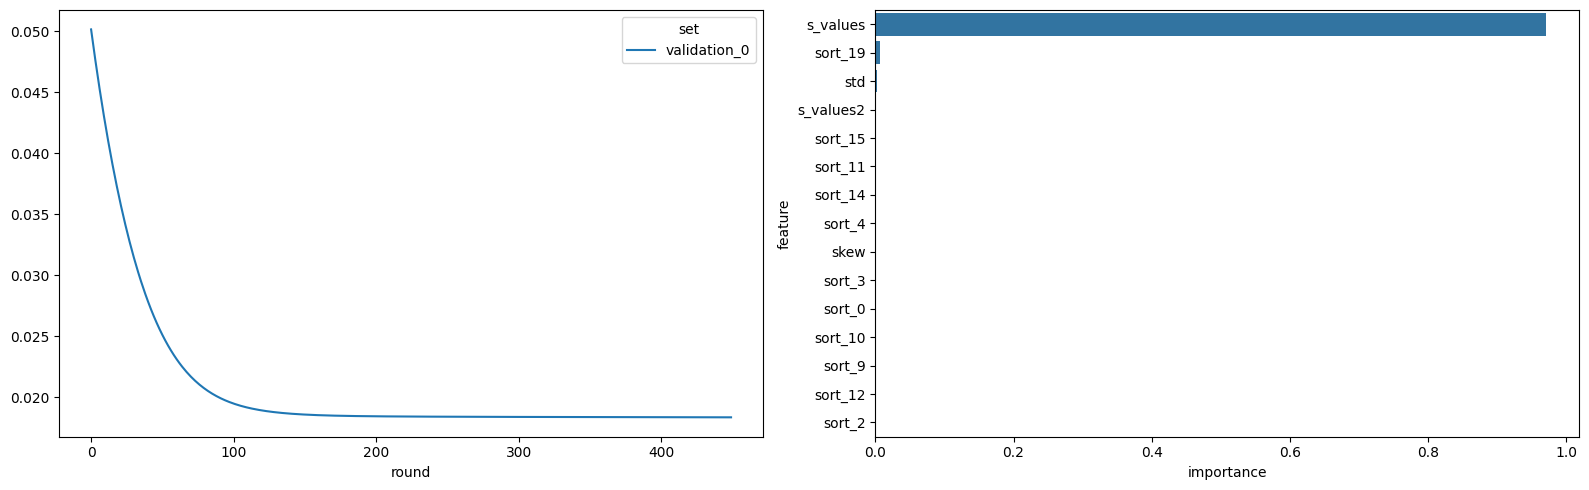

Valid.: 0.86927±0.00025, Train: 0.87042±0.00007


In [32]:
show_gb_cv_result(*stk.get_best_result('xgb2'), metric='rmse')

In [33]:
if not 'xgb2' in stk.get_selected_model():
    m = stk.select_model('xgb2')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [34]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2'])
print_metrics(eval_metrics, train_metrics)

Valid.: 0.86933±0.00026, Train: 0.86933±0.00006


# CatBoost

## cb1

In [35]:
cb_eval = partial(stk.eval_model, model=cb.CatBoostRegressor, result_proc=sgml.cb_learning_result)

In [36]:
m, train_result = cb_eval('cb1', model_params={
        'n_estimators': 800
    },
    X=['MonsoonIntensity'] + X_sort + X_sum + X_stat, 
    train_params={
        'fit_params': {'verbose':False},
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result, 'RMSE')

In [37]:
if not 'cb1' in stk.get_selected_model():
    m = stk.select_model('cb1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

In [38]:
def lr_learning_result(m, train_result):
    return (
        pd.Series(
            m.coef_, index=train_result['variables']
        ).sort_values(),
        train_result
    )

Valid.: 0.86935±0.00026, Train: 0.86935±0.00007


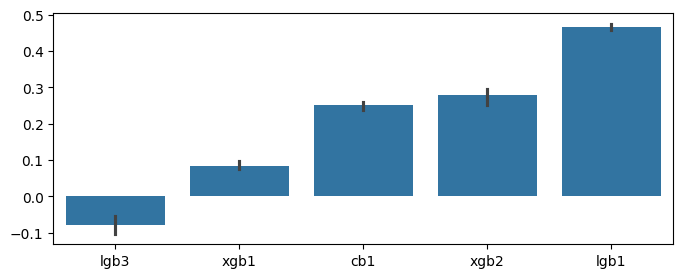

In [39]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

### Submission 3: Ensemble lgb1, lgb3, xgb1, xgb2, cb1

In [40]:
if not os.path.exists(os.path.join(result_path, 'stk_m5.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m5.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m5.csv -m "stk_m5"

Public Score: 0.86927

# Neural Networks

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

## NN1

Neural Network는 데이터 분석 단계에서 다른 GB 모델에 비해 낮은 성능을 보였지만, 다른 양상의 결과를 보이고 있어 포함을 시켜봅니다.

In [42]:
m, train_result = stk.eval_model(
    'nn1', sgnn.NNRegressor, 
    model_params={
        'network_config': [
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 128, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 64, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            {'unit': 32, 'activation': 'relu', 'batch_norm': True}
        ],
        'batch_size': 1024,
        'shuffle_size': 2048000,
        'verbose': 0,
        'validation_fraction': 0.1,
        'learning_rate': 0.001,
        'reduce_lr_on_plateau': {'factor': 0.1, 'patience': 5},
        'early_stopping': {'patience': 5},
        'epochs': 150
    },
    X=[X_sort[0], X_sort[-2], X_sort[-1]] + ['s_values', 's_values2', 'special1'], 
    preprocessor=ColumnTransformer([
        ('std', StandardScaler(), [X_sort[0], X_sort[-2], X_sort[-1]] + ['s_values', 's_values2']),
        ('pt', 'passthrough', ['special1'])
    ]),
    train_params={
        'fit_params': {'metrics': [tf.keras.metrics.R2Score()]}
    }
)

In [43]:
print_metrics(m['train_metrics'], m['valid_metrics'])

Valid.: 0.86328±0.00089, Train: 0.86263±0.00111


In [44]:
if not 'nn1' in stk.get_selected_model():
    m = stk.select_model('nn1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86936±0.00026, Train: 0.86937±0.00006


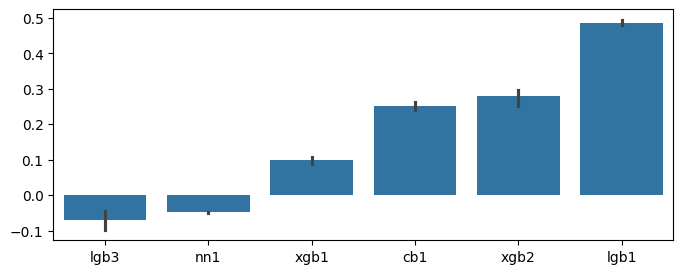

In [45]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

### Submission 4: Ensemble lgb1, lgb3, xgb1, xgb2, cb1, nn1

In [46]:
if not os.path.exists(os.path.join(result_path, 'stk_m6.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m6.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m6.csv -m "stk_m6"

Public Score: 0.86929 

약 0.00002의 성능 향상이 있었습니다.

In [47]:
from IPython.display import Image
img_path = 'img'
def cache_fig(img_name, img_func, nrow, ncol, figsize, redraw=False):
    img_file_name = os.path.join(img_path, img_name + '.png')
    if not os.path.exists(img_file_name) or redraw:
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        if nrow * ncol > 1:
            img_func(axes.ravel())
        else:
            img_func(axes)
        plt.tight_layout()
        plt.savefig(img_file_name)
        plt.show()
    else:
        display(Image(filename=img_file_name))

def diff_graph(axes, s_prd, s_res):
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, stk.df_train['FloodProbability']], axis=1), x=s_prd.name, y='FloodProbability', ax=axes[0]
    )
    sns.lineplot(
        pd.concat([(s_prd * 200).astype('int') / 200, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[1]
    )
    axes[1].axhline(0)
    sns.scatterplot(
        pd.concat([s_prd, s_res], axis=1), x=s_prd.name, y=s_res.name, ax=axes[2], s=10, alpha=0.01
    )

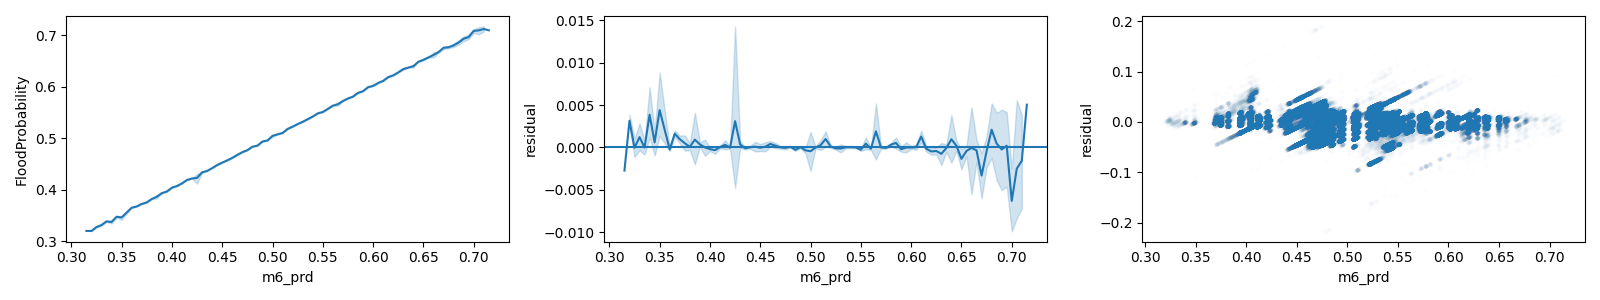

In [48]:
s_res_m6 = (s_prd - stk.df_train['FloodProbability']).rename('residual')
s_prd = s_prd.rename('m6_prd')
cache_fig('m6_diff', 
          partial(diff_graph, s_prd=s_prd, s_res=s_res_m6), 
          nrow=1, ncol=3, figsize=(16, 3))

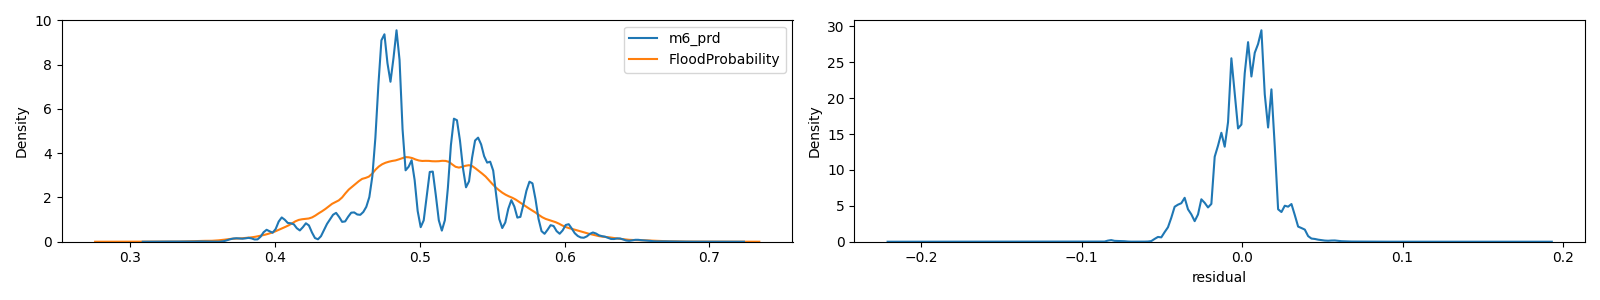

In [49]:
def kde_km_prd_target_residual(axes, s_prd, s_res):
    sns.kdeplot(pd.concat([s_prd, stk.df_train['FloodProbability']], axis=1), ax=axes[0])
    sns.kdeplot(s_res, ax=axes[1])
    
cache_fig(
    'kde_m6_prd_target_residual',
    lambda x: kde_km_prd_target_residual(x, s_prd, s_res_m6), nrow=1, ncol=2, figsize=(16, 3)
)

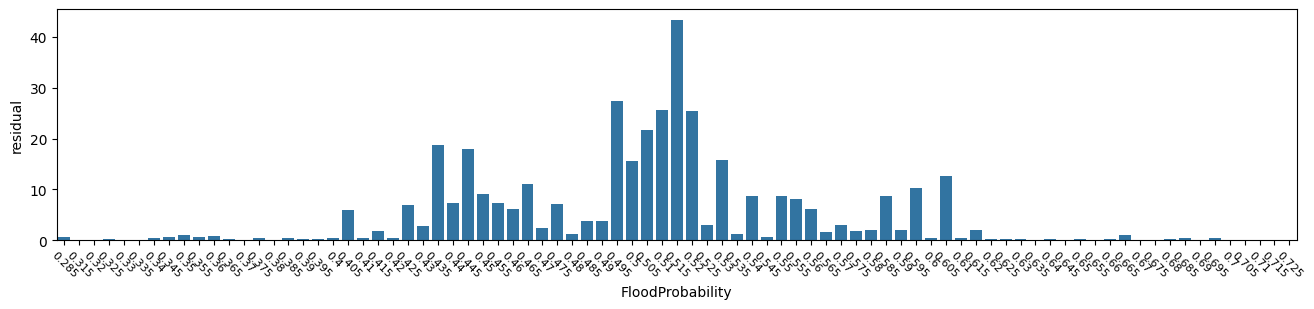

In [50]:
plt.figure(figsize=(16, 3))
sns.barplot((s_res_m6 ** 2).groupby(stk.df_train['FloodProbability']).sum())
plt.xticks(rotation=-45, fontsize=8)
plt.show()

## 예측의 분포와 타겟의 분포가 차이가 나는 지점 분석

### target between (0.4, 0.5)

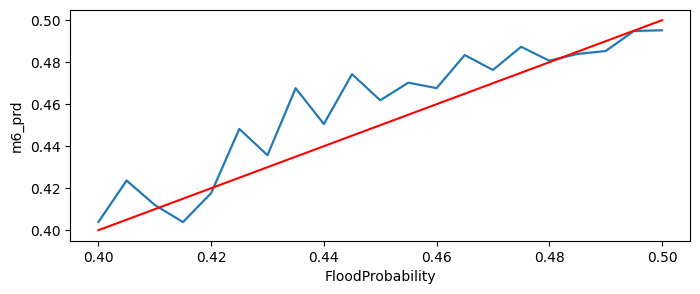

In [51]:
plt.figure(figsize=(8, 3))
s_bidx = stk.df_train['FloodProbability'].between(0.4, 0.5)
sns.lineplot(x=stk.df_train.loc[s_bidx, 'FloodProbability'], y=s_prd.loc[s_bidx])
plt.plot([0.4, 0.5], [0.4, 0.5], color='red')
plt.show()

FloodProbability가 0.425 0.475 의 예측값은 실제값보다 높습니다. 이 구간만을 놓고 모델을 만들어봅니다.

In [52]:
s_bidx = stk.df_train['FloodProbability'].between(0.425, 0.475)
df_tmp = stk.df_train.loc[s_bidx]
((df_tmp['FloodProbability'] - s_prd.loc[s_bidx]) ** 2).sum()

96.87694923786506

In [53]:
((stk.df_train['FloodProbability'] - s_prd) ** 2).sum()

380.25314287454336

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
s_tmp_prd = cross_val_predict(LinearRegression(fit_intercept=False), df_tmp[['s_values']], df_tmp['FloodProbability'], cv=stk.sp)

In [55]:
((df_tmp['FloodProbability'] - s_tmp_prd) ** 2).sum()

28.582792250525078

In [56]:
reg_lr = LinearRegression(fit_intercept=False).fit(df_tmp[['s_values']], df_tmp['FloodProbability'])
reg_lr.coef_

array([0.00489108])

In [57]:
reg_lr = LinearRegression(fit_intercept=False).fit(stk.df_train[['s_values']], stk.df_train['FloodProbability'])
reg_lr.coef_

array([0.00511047])

s_values에 대한 계수가 차이가 납니다. 

데이터 분석에서 s_values FloodProbability

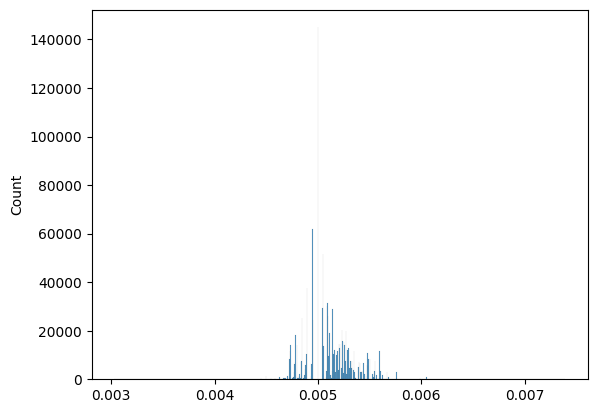

In [58]:
sns.histplot(
    stk.df_train['FloodProbability'] / stk.df_train['s_values']
)
plt.show()

<Axes: xlabel='s_values', ylabel='None'>

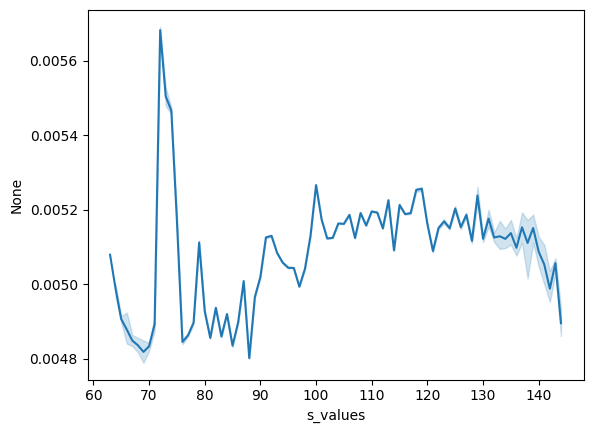

In [59]:
sns.lineplot(
    x=stk.df_train['s_values'], y=stk.df_train['FloodProbability'] / stk.df_train['s_values']
)

FloodProbaility를 맞추는 것보다는 s_values와 FloodPrbability의 비율을 맞추는 것이 더 쉬울 수 있지 않을까 합니다. 

이를 Data 데이터 분석 단계에서 살펴봅니다.

# Ratio Target Model

분석 단계에서는 원래 target으로 했을 때와 비슷한 성능을 보였습니다. 

분포상으는 target으로 했을 때와 육안으로느 크게 다르지는 않았지만, 보완 역활을 해줄지는 확인해볼만합니다.

### LGB_r1

In [60]:
m, train_result = lgb_eval(
    'lgb_r1', model_params={'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 1000, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X= X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    target_func=ratio_func, target_invfunc=ratio_invfunc,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

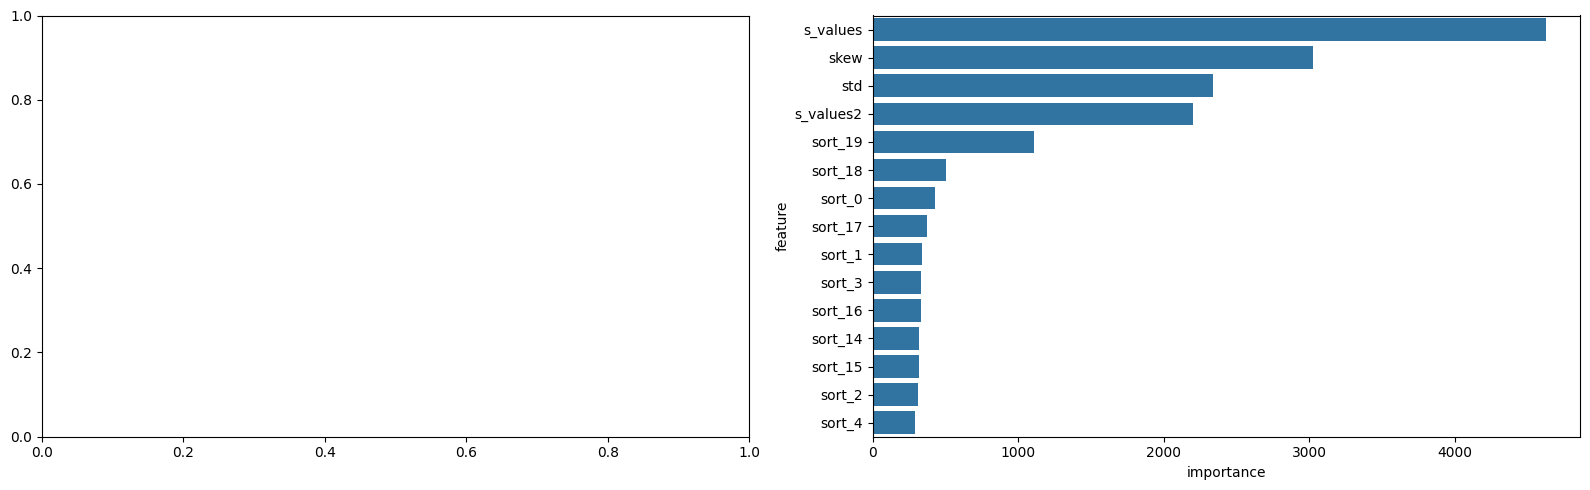

Valid.: 0.86907±0.00026, Train: 0.87027±0.00015


In [61]:
show_gb_cv_result(m, train_result)

In [62]:
stk.get_model_results('lgb_r1').sort_values('valid_metrics', ascending=False).iloc[:3]

,model,preprocessor,model_params,X,train_metrics,valid_metrics,train_info
7,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87058±0.00007,0.86910±0.00026,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."
10,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87058±0.00007,0.86910±0.00026,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."
8,LGBMRegressor,None,"{'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 220, 'num_leaves': 96, 'min_child_samples...","sort_0,sort_1,sort_2,sort_3,sort_4,sort_5,sort_6,sort_7,sort_8,sort_9,sort_10,sort_11,sort_12,so...",0.87040±0.00007,0.86908±0.00026,"{'result_proc': <function lgb_learning_result at 0x7fcc551ee0c0>, 'train_data_proc': None, 'trai..."


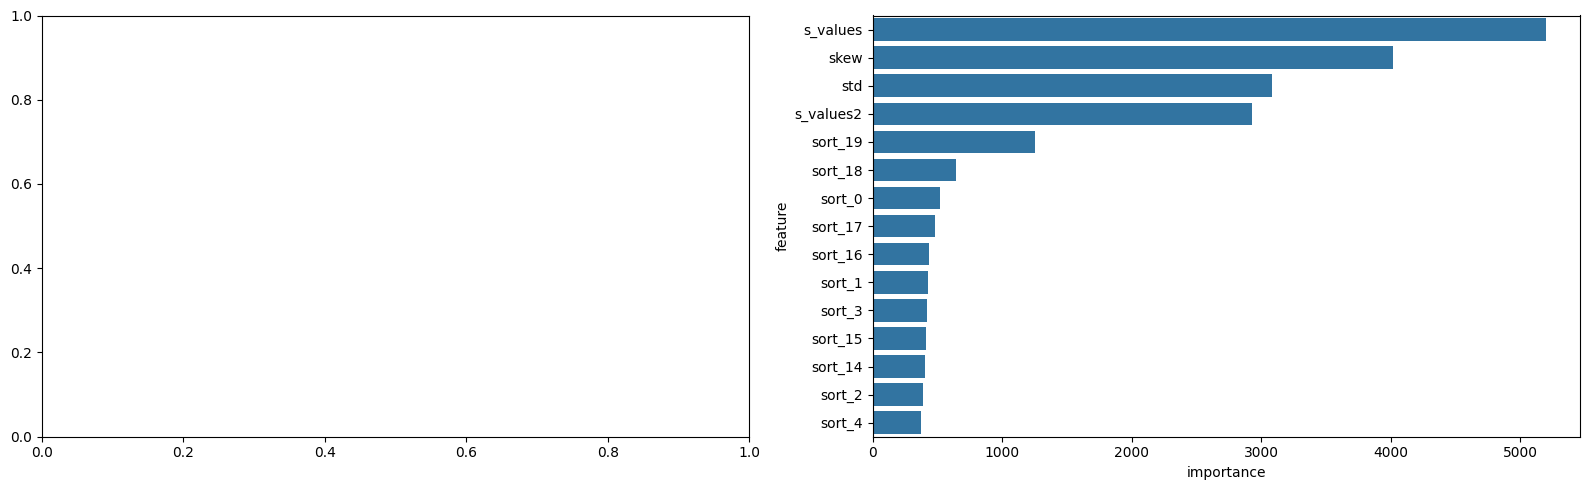

Valid.: 0.86910±0.00026, Train: 0.87058±0.00007


In [63]:
m, train_result = lgb_eval(
    'lgb_r1', model_params={'verbose': -1, 'learning_rate': 0.03, 'n_estimators': 250, 'num_leaves': 96, 'min_child_samples': 32, 'subsample_freq': 1, 'subsample': 0.75}, 
    X= X_sort + X_sum + X_stat, 
    result_proc=sgml.lgb_learning_result,
    target_func=ratio_func, target_invfunc=ratio_invfunc,
    train_params={
        'fit_params': {'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)
show_gb_cv_result(m, train_result)

In [64]:
if not 'lgb_r1' in stk.get_selected_model():
    m = stk.select_model('lgb_r1')
    stk.save_model(os.path.join(result_path, 'stk_s4_ep5.pkl'))

Valid.: 0.86937±0.00026, Train: 0.86937±0.00006


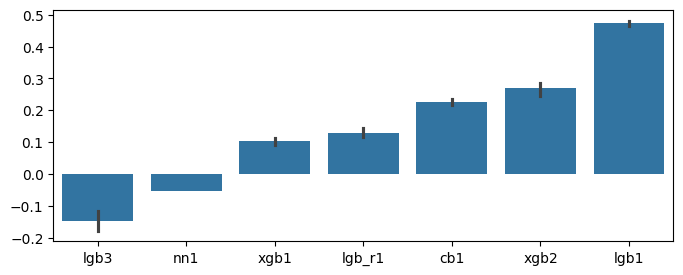

In [65]:
train_metrics, eval_metrics, s_prd, train_result = stk.eval_meta_model(
    LinearRegression, 
    {'fit_intercept':False}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1', 'lgb_r1'], result_proc=lr_learning_result
)
print_metrics(eval_metrics, train_metrics)
plt.figure(figsize=(8, 3))
sns.barplot(pd.concat([i[0] for i in train_result], axis=0))
plt.show()

In [66]:
if not os.path.exists(os.path.join(result_path, 'stk_m7.csv')):
    stk.fit(LinearRegression, {}, ['lgb1', 'lgb3', 'xgb1', 'xgb2', 'cb1', 'nn1', 'lgb_r1'])
    pd.Series(stk.predict(df_test), index=df_test.index).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'stk_m7.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/stk_m7.csv -m "stk_m7"

/home/sun9sun9/python312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [11:40:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
I0000 00:00:1716291649.444006  116253 service.cc:145] XLA service 0x7fcb44004b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716291649.444030  116253 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-05-21 11:40:49.449659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, se

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.86MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

Public Score: 0.86926 성능이 떨어졌다.

# Ensembling with others

## e1

e1: stk_m6

e2: https://www.kaggle.com/code/ravaghi/s04e05-flood-prediction-ensemble/notebook



In [85]:
!kaggle kernels output ravaghi/s04e05-flood-prediction-ensemble 

In [99]:
if not os.path.exists(os.path.join(result_path, 'e1.csv')):
    pd.concat([
        pd.read_csv('result/stk_m6.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/ensemble.csv', index_col='id').rename(columns={'FloodProbability': 'e2'})
    ], axis=1).dot([0.7, 0.3]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e1.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e1.csv -m "e1"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.58MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

## e2

e3: https://www.kaggle.com/code/ravaghi/s04e05-flood-prediction-ensemble/notebook

In [101]:
if not os.path.exists('data/e3.csv'):
    !kaggle kernels output aspillai/flood-prediction-regression-lightgbm-0-86925
    !rm flood-prediction-regression-lightgbm-0-86925.log 
    !mv submission.csv data/e3.csv

Output file downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/submission.csv
Kernel log downloaded to /home/sun9sun9/jnote/sunkusun9/kaggle/PGS4_ep5/flood-prediction-regression-lightgbm-0-86925.log 


In [104]:
if not os.path.exists(os.path.join(result_path, 'e2.csv')):
    pd.concat([
        pd.read_csv('result/stk_m6.csv', index_col='id').rename(columns={'FloodProbability': 'e1'}),
        pd.read_csv('data/ensemble.csv', index_col='id').rename(columns={'FloodProbability': 'e2'}),
        pd.read_csv('data/e3.csv', index_col='id').rename(columns={'FloodProbability': 'e3'}),
    ], axis=1).dot([0.65, 0.25, 0.1]).rename('FloodProbability').to_frame().to_csv(os.path.join(result_path, 'e2.csv'))
    !kaggle competitions submit -c playground-series-s4e5 -f result/e2.csv -m "e2"

100%|██████████████████████████████████████| 19.3M/19.3M [00:04<00:00, 4.86MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset